# Evaluation and Visualisation of Results on Indiviual Dataset

This is most useful for inspection for a single dataset on a particular model

In [1]:
import argparse
import joblib
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import shutil
import sys
import seaborn as sns
import tensorflow as tf

from itertools import cycle
from numpy import interp
from pathlib import Path
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from tensorflow import keras

from astronet.constants import astronet_working_directory as asnwd
from astronet.preprocess import one_hot_encode
from astronet.utils import astronet_logger, load_dataset

In [2]:
from astronet.metrics import WeightedLogLoss
from astronet.visualise_results import plot_acc_history, plot_confusion_matrix, plot_loss_history, plot_multiROC

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.serif": ["Computer Modern Roman"]})

mpl.style.use("seaborn")

In [4]:
architecture = "t2"

In [5]:
dataset = "plasticc"

In [6]:
X_train, y_train, X_test, y_test, loss = load_dataset(dataset)

In [7]:
num_classes = y_train.shape[1]
num_classes

3

In [8]:
with open(f"{asnwd}/astronet/{architecture}/models/{dataset}/results.json") as f:
    events = json.load(f)
    # Get params for best model with lowest loss
    event = min(events['training_result'], key=lambda ev: ev['loss'])

In [9]:
# Show short summary of items in 'event'
dict(list(event.items())[1:4])

{'embed_dim': 64, 'ff_dim': 64, 'hypername': '1605740217-fc9021e'}

In [10]:
model_name = event['name']

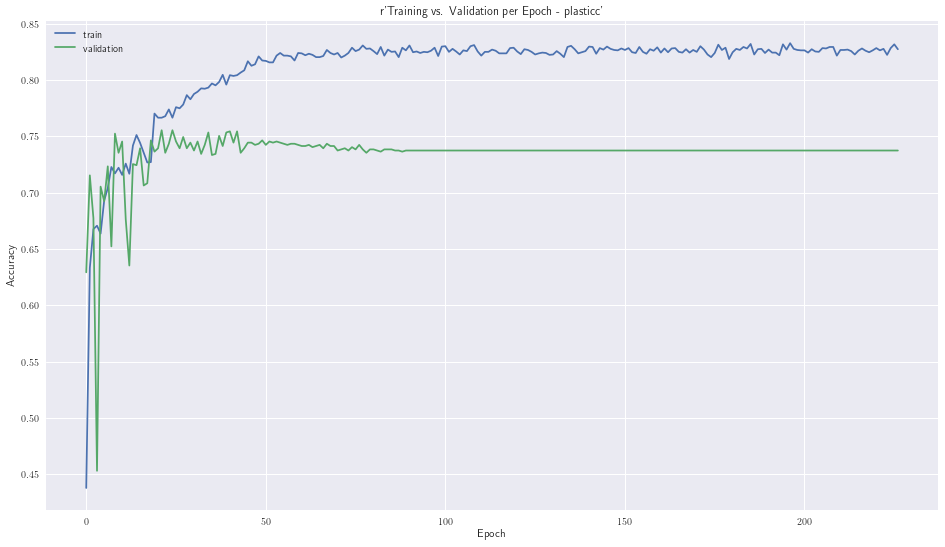

In [11]:
plot_acc_history(dataset, model_name, event, save=False)

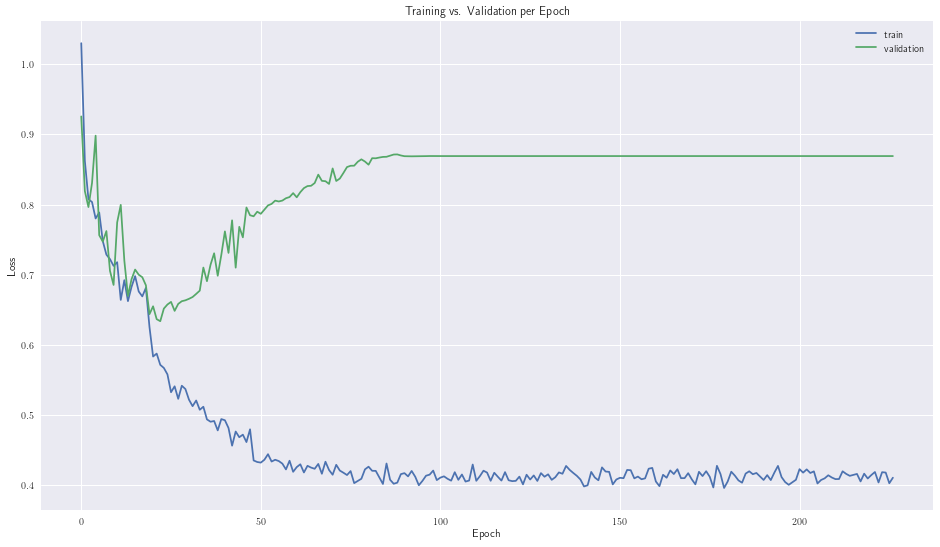

In [12]:
plot_loss_history(dataset, model_name, event, save=False)

In [13]:
model = keras.models.load_model(f"{asnwd}/astronet/{architecture}/models/{dataset}/model-{model_name}", 
                                custom_objects={'WeightedLogLoss': WeightedLogLoss()}, 
                               compile=False)

In [14]:
y_pred = model.predict(X_test)

In [15]:
with open(f"{asnwd}/data/{dataset}.encoding", "rb") as eb:
    encoding = joblib.load(eb)
class_encoding = encoding.categories_[0]

if dataset == "plasticc":
    class_mapping = {
        15: "TDE",
        42: "SNII",
        52: "SNIax",
        62: "SNIbc",
        64: "KN",
        67: "SNIa-91bg",
        88: "AGN",
        90: "SNIa",
        95: "SLSN-I",
        1: "SNIa",
        2: "SNII",
        3: "SNIbc",
    }

    class_encoding
    class_names = list(np.vectorize(class_mapping.get)(class_encoding))
else:

    class_names = class_encoding

In [16]:
y_true = encoding.inverse_transform(y_test)

1611287613-0b0d4b0


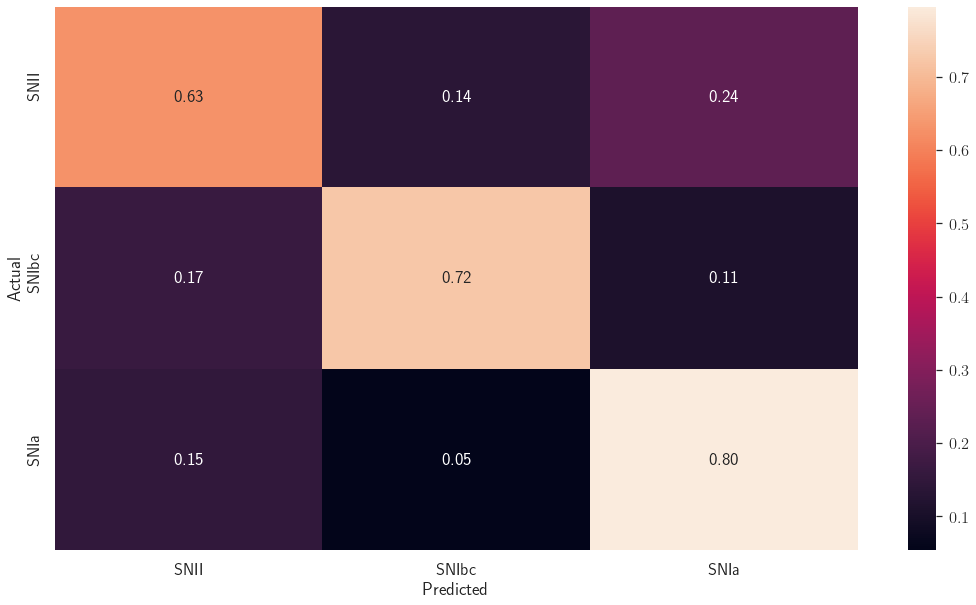

In [17]:
plot_confusion_matrix(
    dataset,
    model_name,
    encoding.inverse_transform(y_test),
    encoding.inverse_transform(y_pred),
    class_names,  # enc.categories_[0]
    save=False,
)

1611287613-0b0d4b0


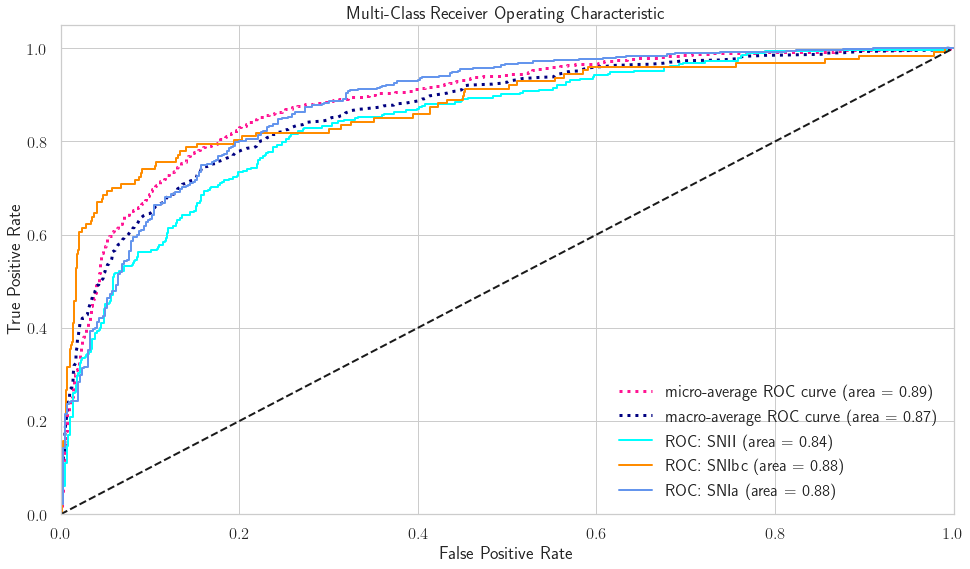

In [18]:
plot_multiROC(dataset, model_name, model, X_test, y_test, class_names, save=False)